In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

stock_data = pd.read_csv('fulldata.csv')


In [2]:
target = ['Close']
features = ['Transaction','Open', 'High', 'Low']
df = stock_data[features + target]

In [3]:
# split the data
split = int(df.shape[0] * 0.8)
df_train = df.iloc[:split, :].copy()
df_test = df.iloc[split:, :].copy()

# scale the data
target_scaler = MinMaxScaler().fit(df_train[target])
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df_train[features])
df_train[features] = features_scaler.transform(df_train[features])
df_test[features] = features_scaler.transform(df_test[features])


In [4]:
# extract the input sequences and output values
sequence_length = 5

X_train, y_train = [], []

for i in range(sequence_length, df_train.shape[0]):
    X_train.append(df_train[features + target].iloc[i - sequence_length: i])
    y_train.append(df_train[target].iloc[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []

for i in range(sequence_length, df_test.shape[0]):
    X_test.append(df_test[features + target].iloc[i - sequence_length: i])
    y_test.append(df_test[target].iloc[i])

X_test, y_test = np.array(X_test), np.array(y_test)

In [14]:
# build and train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
# model.add(LSTM(units=200, activation="tanh", return_sequences=False))
# model.add(Dropout(0.2))
# model.add(LSTM(units=20, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=60, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=120, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(units=50))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 50)             11200     
                                                                 
 dropout_3 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 72,621
Trainable params: 72,621
Non-trai

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

train_history=model.fit(X_train, y_train, epochs=50, batch_size=64)

model.evaluate(X_test, y_test)

#save the model
# model.save('save\LSTM_eps50_bsize64.h5')

# generate the test set predictions
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)

Epoch 1/50
32/32 [==============================] - 2s 8ms/step - loss: 0.0146
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 6.5329e-04
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 7.4891e-04
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 6.4873e-04
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 6.5887e-04
Epoch 7/50
32/32 [==============================] - 0s 8ms/step - loss: 5.8007e-04
Epoch 8/50
32/32 [==============================] - 0s 8ms/step - loss: 5.1960e-04
Epoch 9/50
32/32 [==============================] - 0s 8ms/step - loss: 4.9801e-04
Epoch 10/50
32/32 [==============================] - 0s 8ms/step - loss: 5.3034e-04
Epoch 11/50
32/32 [==============================] - 0s 7ms/step - loss: 5.4638e-04
Epoch 12/50
32/32 [==============================] - 0s 8ms/step - loss: 5.2073e-04
Epoch 13/

In [16]:
df['Predicted'] = np.nan
df['Predicted'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
res=pd.concat([stock_data['DateTime'],df],axis=1)
test=res[['DateTime','Open','Close', 'Predicted']].dropna().reset_index()
test

,index,DateTime,Open,Close,Predicted
0,2016,2021-03-31,596.0,587.0,607.219238
1,2017,2021-04-01,598.0,602.0,608.488708
2,2018,2021-04-06,615.0,610.0,611.742859
3,2019,2021-04-07,614.0,610.0,616.295044
4,2020,2021-04-08,606.0,613.0,620.113892
5,2021,2021-04-09,618.0,610.0,624.066467
6,2022,2021-04-12,612.0,605.0,628.295105
7,2023,2021-04-13,604.0,605.0,629.862427
8,2024,2021-04-14,608.0,612.0,628.601379
9,2025,2021-04-15,612.0,619.0,627.572083


In [17]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

test.loc[test.Close.shift(1) >= test.Close, "Trend"]= 0
test.loc[test.Close.shift(1) < test.Close, "Trend"]= 1
test['Trend']=test['Trend'].fillna(0).astype(int)
test.loc[test.Predicted.shift(1) >= test.Predicted, "PredTrend"]= 0
test.loc[test.Predicted.shift(1) < test.Predicted, "PredTrend"]= 1
test['PredTrend']=test['PredTrend'].fillna(0).astype(int)
test.loc[test.Predicted.shift(1) >= test.Close.shift(1), "PredvsTrend"]= 0
test.loc[test.Predicted.shift(1) < test.Close.shift(1), "PredvsTrend"]= 1
test['PredvsTrend']=test['PredvsTrend'].fillna(0).astype(int)


test['status'] = test.PredTrend.shift(1).fillna(0).astype(int)
test['status2']=test.status
test.loc[( (test.status.shift(1)==0) & (test.status==1) ) & (test.Close.shift(1)<=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status2"]= 0
test.loc[( (test.status.shift(1)==1) & (test.status==0) ) & (test.Close.shift(1)>=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status2"]= 1
# test['status2']=test['status2'].fillna(0).astype(int)
# test['status2']=test['status2']

# 做一條predict的均線試看看

test['status3']= test.PredvsTrend.shift(1).fillna(0).astype(int)
test.loc[( (test.PredvsTrend.shift(1)==0) & (test.PredvsTrend==1) ) & (test.Close.shift(1)<=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status3"]= 0
test.loc[( (test.PredvsTrend.shift(1)==1) & (test.PredvsTrend==0) ) & (test.Close.shift(1)>=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status3"]= 1

test['status'] = test.status3.astype(int)


# .shift(1)是前一個

test['buy_cost'] = test.Open[np.where((test.status3 == 1) * (test.status3.shift(1) == 0))[0]]
test['sell_cost'] = test.Open[np.where((test.status3 == 0) * (test.status3.shift(1) == 1))[0]]

test = test.fillna(0)
buy_cost = np.array(test.buy_cost[test.buy_cost != 0])
sell_price = np.array(test.sell_cost[test.sell_cost != 0])

if len(buy_cost) > len(sell_price) :
    buy_cost = buy_cost[:-1]

trade_return = sell_price / buy_cost - 1
fee = 0.002
net_trade_return = trade_return - fee

test['trade_ret'] = 0
test['net_trade_ret'] = 0
sell_dates = test.sell_cost[test.sell_cost != 0].index
test.loc[sell_dates, 'trade_ret'] = trade_return
test.loc[sell_dates, 'net_trade_ret'] = net_trade_return

test['open_ret'] = test.Open / test.Open.shift(1) - 1
test['strategy_ret'] = test.status.shift(1) * test.open_ret
test['strategy_net_ret'] = test.strategy_ret
test.loc[sell_dates, 'strategy_net_ret'] = test.loc[sell_dates, 'strategy_net_ret'] - fee
test = test.fillna(0)

test['buy_and_hold_equity'] = (test.open_ret + 1).cumprod()
test['strategy_equity'] = (test.strategy_ret + 1).cumprod()
test['strategy_net_equity'] = (test.strategy_net_ret + 1).cumprod()

test

,index,DateTime,Open,Close,Predicted,Trend,PredTrend,PredvsTrend,status,status2,status3,buy_cost,sell_cost,trade_ret,net_trade_ret,open_ret,strategy_ret,strategy_net_ret,buy_and_hold_equity,strategy_equity,strategy_net_equity
0,2016,2021-03-31,596.0,587.0,607.219238,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
1,2017,2021-04-01,598.0,602.0,608.488708,1,1,0,0,0,0,0.0,0.0,0.000000,0.000000,0.003356,0.000000,0.000000,1.003356,1.000000,1.000000
2,2018,2021-04-06,615.0,610.0,611.742859,1,1,0,0,1,0,0.0,0.0,0.000000,0.000000,0.028428,0.000000,0.000000,1.031879,1.000000,1.000000
3,2019,2021-04-07,614.0,610.0,616.295044,0,1,0,0,1,0,0.0,0.0,0.000000,0.000000,-0.001626,-0.000000,-0.000000,1.030201,1.000000,1.000000
4,2020,2021-04-08,606.0,613.0,620.113892,1,1,0,0,1,0,0.0,0.0,0.000000,0.000000,-0.013029,-0.000000,-0.000000,1.016779,1.000000,1.000000
5,2021,2021-04-09,618.0,610.0,624.066467,0,1,0,0,1,0,0.0,0.0,0.000000,0.000000,0.019802,0.000000,0.000000,1.036913,1.000000,1.000000
6,2022,2021-04-12,612.0,605.0,628.295105,0,1,0,0,1,0,0.0,0.0,0.000000,0.000000,-0.009709,-0.000000,-0.000000,1.026846,1.000000,1.000000
7,2023,2021-04-13,604.0,605.0,629.862427,0,1,0,0,1,0,0.0,0.0,0.000000,0.000000,-0.013072,-0.000000,-0.000000,1.013423,1.000000,1.000000
8,2024,2021-04-14,608.0,612.0,628.601379,1,0,0,0,1,0,0.0,0.0,0.000000,0.000000,0.006623,0.000000,0.000000,1.020134,1.000000,1.000000
9,2025,2021-04-15,612.0,619.0,627.572083,1,0,0,0,1,0,0.0,0.0,0.000000,0.000000,0.006579,0.000000,0.000000,1.026846,1.000000,1.000000


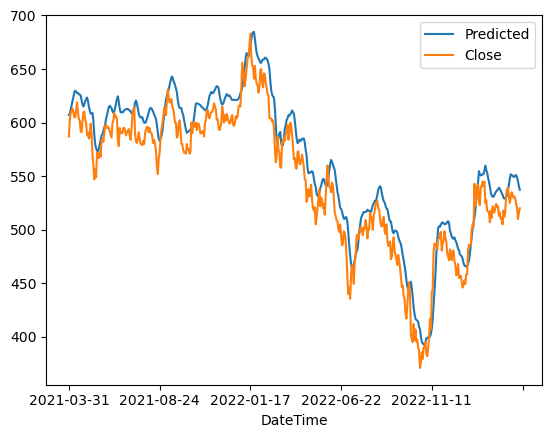

In [18]:
plot=test.plot(x='DateTime',y=['Predicted','Close'])
fig = plot.get_figure()

Text(0, 0.5, 'strategy_equity')

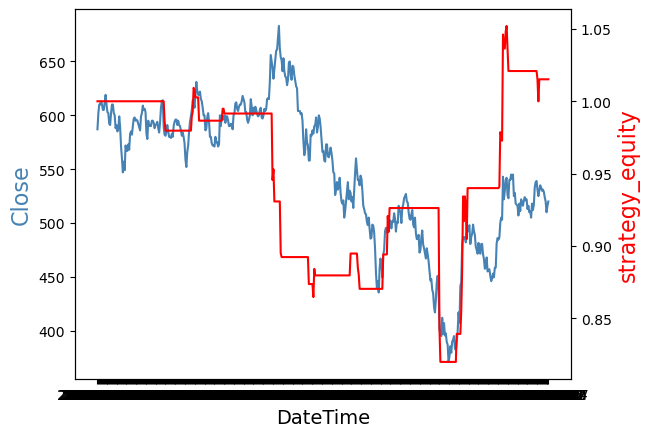

In [19]:
col1 = 'steelblue'
col2 = 'red'
col3 = 'green'
fig2,ax = plt.subplots()
ax.plot(test.DateTime, test.Close, color=col1)
ax.set_xlabel('DateTime', fontsize=14)
ax.set_ylabel('Close', color=col1, fontsize=16)
ax2 = ax.twinx()
ax2.plot(test.DateTime, test.strategy_equity, color=col2)
ax2.set_ylabel('strategy_equity', color=col2, fontsize=16)

In [20]:
# 如果train的結果很好再存
# model.save('save\BEST-2.h5')
# fig2.savefig("save\BEST-2.png")

In [21]:
res=pd.concat([stock_data['DateTime'],df],axis=1)
dfpred=res[['DateTime','Open','Close', 'Predicted']].dropna()
dfpred

,DateTime,Open,Close,Predicted
2016,2021-03-31,596.0,587.0,607.219238
2017,2021-04-01,598.0,602.0,608.488708
2018,2021-04-06,615.0,610.0,611.742859
2019,2021-04-07,614.0,610.0,616.295044
2020,2021-04-08,606.0,613.0,620.113892
2021,2021-04-09,618.0,610.0,624.066467
2022,2021-04-12,612.0,605.0,628.295105
2023,2021-04-13,604.0,605.0,629.862427
2024,2021-04-14,608.0,612.0,628.601379
2025,2021-04-15,612.0,619.0,627.572083


In [22]:
# dfpred.to_csv('source\pred.csv', encoding='utf-8',index=None)
model.save('nowstock.h5')
